# Car ownership calibration 

In [1]:
import numpy as np 
import pandas as pd 
import time
import orca 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from sklearn.model_selection import KFold, train_test_split
from statsmodels.discrete.discrete_model import MNLogit

In [2]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  20002
Number of Persons:  49565
Number of tours:  63481
Number of trips:  161435


In [3]:
def simulation(probs):
    'Monte Carlo simulation'
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [4]:
def run_car_ownership(values, coeffs):
    'Returns auto_ownership value'
    utils = (values @ coeffs).astype(float)
    utils_exp = utils.apply(np.exp)
    probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
    choices = simulation(probs)
    return choices

In [5]:
def car_ownership_validation(hh):
    ''' Validation tool for car ownership model
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'True value']
    
    #Plot
    g = sns.lmplot('True value','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("H3-to-H3 Car ownerwhip \n ActivitySim", y=1.05, fontsize = 15);

In [6]:
def add_simulation_vars(households, accessibilities, land_use):
    
    #Merge accesibilities and land use variables 
    hh_merge = hh.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['num_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['num_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['num_drivers_4+'] = hh_merge.num_drivers > 3
    hh_merge['children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['num_workes_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['income_30'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['income_75'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['income_125'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['density_10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['density_10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['constant'] = 1
    
    #Accessibility_based variables
    hh_merge['retail_0w_auto'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_+1w_auto'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_0w_transit'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_+1w_transit'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_0w_nm'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['retail_+1w_nm'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['auto_saving_work'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

In [7]:
def grid_search(var_to_replace, coeff, hh_merge, var_names, iterations = 100):
    '''
    Grid-like search algortihm to estimate the best parameters to maximize prediction of car ownership share
    Input: 
    - var_to_replace: list of 12 arrays. Each array contains the range for each coefficient. 
                    List in the following order: 
                    0. Constant 1_car
                    1. Constant 2_car
                    2. Constant 3_car
                    3. Constant 4_car
                    4. driver_2 1_car
                    5. driver_2 2_car
                    6. driver_2 3_car
                    7. driver_2 4_car
                    8. driver_3 1_car
                    9. driver_3 2_car
                    10. driver_3 3_car
                    11. driver_3 4_car
    - coeff: The coefficients dataframe
    - hh_merge: choosers
    - var_name: should be coefficient indexes and all var should be in hh_merge
    - iteration: Number of random sets for the gris like-search (since there are a lot of options,I select some of them)
    
    Return 
    Dataframe with "iteration" amount of rows
    Each row with one combination of the 12 varaibles, and the corresponding score. 
    '''
    #Generate random set of coefficients 
    sample_list = []
    for var in vars_to_replace:
        random_sample = np.random.choice(var, iterations, replace = True)
        sample_list.append(random_sample)

    grid_rands = np.array(sample_list).T
    
    # Run simulation for each random set 
    score_list = []
    row_list = ['constant','num_drivers_2','num_drivers_3']
    col_list = ['cars1', 'cars2', 'cars3','cars4']
    for row in grid_rands:
        
        #Replace random set coefficients 
        counter = 0 
        for row_coeff in row_list: 
            for col_coeff in col_list: 
                coeff.loc[row_coeff,col_coeff] = row[counter]
                counter += 1

        # Run model 
        choices = run_car_ownership(hh_merge[var_names], coeff)
        hh_merge['auto_ownership'] = choices 
        
        #Score
#         score = ((hh_merge['cars'] - hh_merge['auto_ownership'])**2).sum()/hh_merge.shape[0]
    #     score = sklearn.metrics.f1_score(hh_merge['cars'], hh_merge['auto_ownership'], average = 'weighted')
    #     cross_tab = pd.crosstab(hh_merge.VEHICL, hh_merge.auto_ownership, normalize= 'all')
    #     score = np.diagonal(cross_tab).sum()
        score = np.abs((hh_merge.cars.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
        score_list.append(score)

    
    results_join = pd.DataFrame(grid_rands)
    results_join['score'] = score_list
    
    return results_join

In [8]:
hh_merge = add_simulation_vars(hh, acc, lu) 

## Grid search 
This part will take care of the grid search
- Create arrays for each parameter that will be included in the serach. Specify a lower and upper bound. 
- Built random combination sets of coefficients (All combinations take a lot to run) 
- Run simulation with random set of coefficients and store score result
- Organize scores in a table to compare results
- Replaces coefficients that resulted optimize score. 

In [9]:
var_names = ['num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
             'density_+10_0w','density_10_+1w', 'density_+10_+1w','constant', 
             'retail_0w_auto','retail_+1w_auto', 'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 'retail_+1w_nm', 'auto_saving_work']


# Read csv file 
coeff_csv = pd.read_csv('configs/auto_ownership.csv')
coeff = coeff_csv.fillna(0)[['cars0', 'cars1', 'cars2', 'cars3', 'cars4']]
coeff.index = var_names

In [10]:
#Initial values:
var0 = np.linspace(0,5,11)
var1 = np.linspace(0,5,11)
var2 = np.linspace(-5,0,11)
var3 = np.linspace(-5,0,11)

# +-20% of the original coefficient. 
var4 = np.linspace(-1,0,101)
var5 = np.linspace(3.0773 - 0.47,3.0773 + 0.47,11)
var6 = np.linspace(3.1962 - 0.48,3.1962 + 0.48,11)
var7 = np.linspace(2.6616 - 0.40,2.6616 + 0.400,11)

var8 = np.linspace(-2,0,11)
var9 = np.linspace(3.5401 - 0.54,3.5401 + 0.54,11)
var10 = np.linspace(5.513 - 0.83,5.5131 - 0.83,11)
var11 = np.linspace(5.208 - 0.79,5.2080 + 0.79,11)

vars_to_replace = [var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10, var11]

In [11]:
#Final range search
var0 = np.linspace(4.3,4.5,101)
var1 = np.linspace(1.5,1.8,101)
var2 = np.linspace(-0.5,-0.3,101)
var3 = np.linspace(-2.7,-2.5,101)

var4 = np.linspace(-1,-0.7,101)
var5 = np.linspace(3.1,3.4,101)
var6 = np.linspace(2.9,3.3,101)
var7 = np.linspace(2.6, 3.0,101)

var8 = np.linspace(-2.3,-1.6,101)
var9 = np.linspace(3.4, 3.8,101)
var10 = np.linspace(4.6, 4.7,101)
var11 = np.linspace(4.8,5.2,101)

vars_to_replace = [var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10, var11]

In [12]:
%%time
grid_results = grid_search(vars_to_replace, coeff, hh_merge, var_names, iterations = 1000)
grid_results.sort_values('score').head(10)

CPU times: user 1min 49s, sys: 1.33 s, total: 1min 51s
Wall time: 1min 51s


,0,1,2,3,4,5,6,7,8,9,10,11,score
334,4.472,1.524,-0.458,-2.580,-0.712,3.163,3.000,2.636,-2.139,3.492,4.611,4.860,828
622,4.486,1.593,-0.466,-2.536,-0.748,3.136,3.184,2.896,-1.733,3.696,4.676,5.104,836
365,4.484,1.527,-0.476,-2.596,-0.778,3.115,3.064,2.864,-2.055,3.476,4.607,4.836,916
213,4.448,1.551,-0.386,-2.700,-0.769,3.103,2.968,2.924,-1.642,3.592,4.682,4.872,932
174,4.488,1.596,-0.352,-2.544,-0.715,3.235,3.128,2.748,-1.726,3.596,4.645,5.160,938
951,4.410,1.557,-0.398,-2.624,-0.745,3.100,2.920,2.728,-1.691,3.720,4.627,4.992,960
418,4.478,1.605,-0.400,-2.604,-0.754,3.106,2.992,2.976,-1.908,3.632,4.637,4.880,986
556,4.444,1.503,-0.366,-2.648,-0.799,3.115,2.988,2.992,-1.873,3.660,4.696,4.976,992
436,4.440,1.533,-0.354,-2.636,-0.715,3.289,2.928,2.880,-1.866,3.512,4.615,5.172,1022
211,4.492,1.500,-0.368,-2.572,-0.949,3.118,2.904,2.864,-2.027,3.684,4.664,5.152,1044


In [13]:
#Replacing best coefficients in coeff file
best_coeffs = grid_results[grid_results.score == grid_results.score.min()]

#TO ASK: Should I get the coefficients with the min score, 
#or an average of the top10 (or more) coefficients. 
row_list = ['constant','num_drivers_2','num_drivers_3']
col_list = ['cars1', 'cars2', 'cars3','cars4']

counter = 0 
for row in row_list: 
    for col in col_list: 
        coeff.loc[row,col] = best_coeffs.iloc[0,counter]
        counter += 1

   cars  auto_ownership  diff
0   728             950  -222
1  7143            6748   395
2  8668            8783  -115
3  2574            2641   -67
4   889             880     9


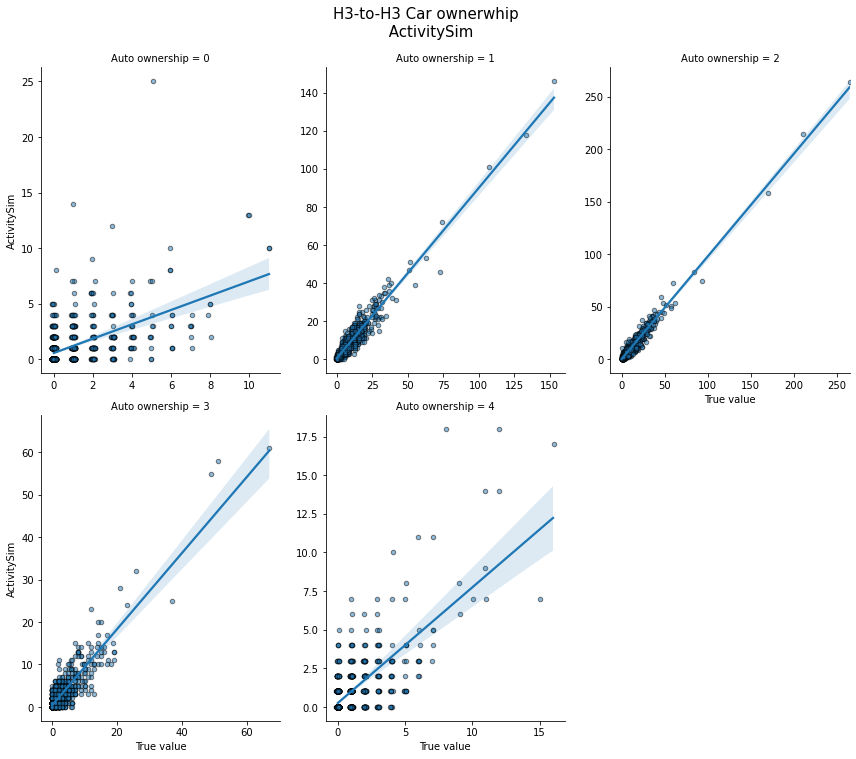

In [14]:
# Run model 
choices = run_car_ownership(hh_merge[var_names], coeff)
hh_merge['auto_ownership'] = choices 

#Results
comparison = pd.concat((hh_merge['cars'].value_counts(), hh_merge['auto_ownership'].value_counts()), axis = 1)
comparison['diff'] = comparison['cars'] - comparison['auto_ownership']
print(comparison)
# print('-------------------------------------------------')
car_ownership_validation(hh_merge)

## Saving final specification 

In [17]:
coeff.reset_index(inplace = True)
var_list = ['cars0', 'cars1', 'cars2', 'cars3','cars4']
for name in var_list:
    coeff_csv[name] = coeff[name]
coeff_csv = coeff_csv.replace(0, np.nan)
coeff_csv.to_csv('configs/auto_ownership.csv', index = False)

In [16]:
coeff_csv

,Description,Expression,cars0,cars1,cars2,cars3,cars4
0,2 Adults (age 16+),num_drivers==2,NaN,-0.7120,3.1630,3.0000,2.6360
1,3 Adults (age 16+),num_drivers==3,NaN,-2.1390,3.4920,4.6110,4.8600
2,4+ Adults (age 16+),num_drivers>3,NaN,2.0107,6.3662,8.5148,9.5807
3,Persons age 16-17,num_children_16_to_17,NaN,NaN,-0.8810,-1.7313,-1.7313
4,Persons age 18-24,num_college_age,NaN,-0.4087,-1.0095,-1.0107,-1.0107
5,Persons age 35-34,num_young_adults,NaN,NaN,-0.4849,-0.8596,-0.8596
6,Presence of children age 0-4,num_young_children>0,NaN,0.3669,0.7627,0.7627,0.7627
7,Presence of children age 5-17,(num_children_5_to_15+num_children_16_to_17)>0,NaN,0.0158,0.2936,0.4769,0.4769
8,"Number of workers, capped at 3",@df.num_workers.clip(upper=3),NaN,NaN,0.2936,0.6389,0.8797
9,"Piecewise Linear household income, $0-30k","@df.income_in_thousands.clip(0, 30)",NaN,0.0383,0.0540,0.0559,0.0619
